In [1]:
# This notebook takes clustered precipitation events and calculates their statistics on a global grid
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import xarray as xr
import datetime
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Constants

In [2]:
# Open the clustered precipitating pixels
f = xr.open_dataset('2001_01Clustered_Data_Globe150.nc4')
#print(f)
altitude_lh = np.array(f.altitude_lh.copy())
surf_rain = np.array(f.surf_rain.copy())
latent_heating = np.array(f.latent_heating.copy())
latitude = np.array(f.latitude.copy())
longitude = np.array(f.longitude.copy())
time = np.array(f.time.copy())
rain_type = np.array(f.rain_type.copy())
labels = np.array(f.Labels.copy())
nvert = np.size(altitude_lh)
f.close()

# Load in event statistics
f = xr.open_dataset('2001_01_event_means150.nc')
event_time = np.array(f.event_time.copy())
event_lat = np.array(f.event_lat_mean.copy())
event_lon = np.array(f.event_lon_mean.copy())
event_pr = np.array(f.event_pr_mean.copy())
event_lhp = np.array(f.event_lhp_mean.copy())
event_area = np.array(f.event_area.copy())
event_frac_conv = np.array(f.event_frac_conv.copy())
event_frac_strat = np.array(f.event_frac_strat.copy())
event_frac_other = np.array(f.event_frac_other.copy())
cluster = np.array(f.cluster.copy())
altitude_lh = np.array(f.altitude_lh.copy())
nevents = np.size(cluster)
f.close()

In [3]:
# Create a grid
res = 4 # grid resolution (degrees)
lat = -40 + res*np.arange(1+80/res)
lon = -180 + res*np.arange(1+360/res)
latfS = lat - res/2
latfN = lat + res/2
lonfW = lon - res/2
lonfE = lon + res/2
lonfW[0] = -180
lonfE[-1] = 180
nlatgrid = np.size(lat)
nlongrid = np.size(lon)

# Precipitation statistics within the boundaries of those grid cells
npixels = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
conv_frac = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
strat_frac = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
other_frac = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
event_area_gridded = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
rain_sum = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
lhp = np.ndarray(shape=(nlongrid,nlatgrid,nvert), dtype=float)
lhp_max_alt = np.ndarray(shape=(nlongrid,nlatgrid), dtype=float)
for i in np.arange(nlongrid):
    print(i/nlongrid)
    lonmin = lonfW[i]
    lonmax = lonfE[i]
    temp_rain = surf_rain[longitude < lonmax]
    nvals = temp_rain.size
    lon_tile = np.tile(longitude, (nvert,1))
    lon_tile = np.swapaxes(lon_tile, 0, 1)
    temp_lhp = latent_heating[lon_tile < lonmax]
    temp_lhp = np.reshape(temp_lhp, (nvals,nvert))
    temp_type = rain_type[longitude < lonmax]
    temp_label = labels[longitude < lonmax]
    temp_lon = longitude[longitude < lonmax]
    temp_lat = latitude[longitude < lonmax]
    temp_rain = temp_rain[temp_lon >= lonmin]
    nvals = temp_rain.size
    lon_tile = np.tile(temp_lon, (nvert,1))
    lon_tile = np.swapaxes(lon_tile, 0, 1)
    temp_lhp = temp_lhp[lon_tile >= lonmin]
    temp_lhp = np.reshape(temp_lhp, (nvals,nvert))
    temp_type = temp_type[temp_lon >= lonmin]
    temp_label = temp_label[temp_lon >= lonmin]
    temp_lat = temp_lat[temp_lon >= lonmin]
    temp_lon = temp_lon[temp_lon >= lonmin]
    for j in np.arange(nlatgrid):
        latmin = latfS[j]
        latmax = latfN[j]
        temp_rain2 = temp_rain[temp_lat < latmax]
        nvals = temp_rain2.size
        lat_tile = np.tile(temp_lat, (nvert,1))
        lat_tile = np.swapaxes(lat_tile, 0, 1)
        temp_lhp2 = temp_lhp[lat_tile < latmax]
        temp_lhp2 = np.reshape(temp_lhp2, (nvals,nvert))
        temp_type2 = temp_type[temp_lat < latmax]
        temp_label2 = temp_label[temp_lat < latmax]
        temp_lat2 = temp_lat[temp_lat < latmax]
        temp_rain2 = temp_rain2[temp_lat2 >= latmin]
        nvals = temp_rain2.size
        lat_tile = np.tile(temp_lat2, (nvert,1))
        lat_tile = np.swapaxes(lat_tile, 0, 1)
        temp_lhp2 = temp_lhp2[lat_tile >= latmin]
        temp_lhp2 = np.reshape(temp_lhp2, (nvals,nvert))
        temp_type2 = temp_type2[temp_lat2 >= latmin]
        temp_label2 = temp_label2[temp_lat2 >= latmin]
        rain_sum[i,j] = np.nansum(temp_rain2)
        lhp[i,j,:] = np.nanmean(temp_lhp2, axis=0)
        npixels[i,j] = np.size(temp_rain2)
        
        temp = temp_rain2[temp_type2 == 1]
        strat_frac[i,j] = np.nansum(temp)/np.nansum(temp_rain2)
        temp = temp_rain2[temp_type2 == 2]
        conv_frac[i,j] = np.nansum(temp)/np.nansum(temp_rain2)
        temp = temp_rain2[temp_type2 == 3]
        other_frac[i,j] = np.nansum(temp)/np.nansum(temp_rain2)
        
        if npixels[i,j] > 0:
            temp_area = np.ndarray(shape=np.size(temp_rain2), dtype=float)
            lhmax = np.nanmax(temp_lhp2, axis=1)
            lhmax_alt = np.ndarray(shape=np.size(lhmax), dtype=float)
            for k in np.arange(np.size(temp_rain2)):
                temp_area[k] = event_area[temp_label2[k]]
                if lhmax[k] > 0:
                    lhmax_alt[k] = np.mean(altitude_lh[temp_lhp2[k,:] == lhmax[k]])
                else:
                    lhmax_alt[k] = np.nan
            event_area_gridded[i,j] = np.nansum(temp_area*temp_rain2)/np.nansum(temp_rain2)
            lhp_max_alt[i,j] = np.nansum(lhmax*lhmax_alt)/np.nansum(lhmax)
        else:
            event_area_gridded[i,j] = np.nan

0.0
0.01098901098901099
0.02197802197802198
0.03296703296703297
0.04395604395604396
0.054945054945054944
0.06593406593406594
0.07692307692307693
0.08791208791208792
0.0989010989010989
0.10989010989010989
0.12087912087912088
0.13186813186813187
0.14285714285714285
0.15384615384615385
0.16483516483516483
0.17582417582417584
0.18681318681318682
0.1978021978021978
0.2087912087912088
0.21978021978021978
0.23076923076923078
0.24175824175824176
0.25274725274725274
0.26373626373626374
0.27472527472527475
0.2857142857142857
0.2967032967032967
0.3076923076923077
0.31868131868131866
0.32967032967032966
0.34065934065934067
0.3516483516483517
0.3626373626373626
0.37362637362637363
0.38461538461538464
0.3956043956043956
0.4065934065934066
0.4175824175824176
0.42857142857142855
0.43956043956043955
0.45054945054945056
0.46153846153846156
0.4725274725274725
0.4835164835164835
0.4945054945054945
0.5054945054945055
0.5164835164835165
0.5274725274725275
0.5384615384615384
0.5494505494505495
0.560439560439

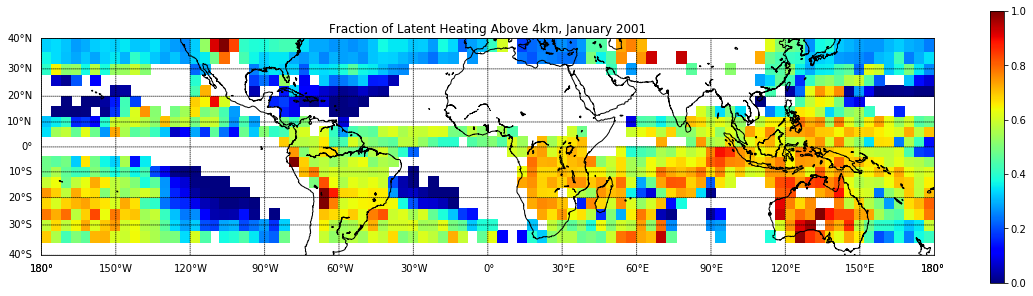

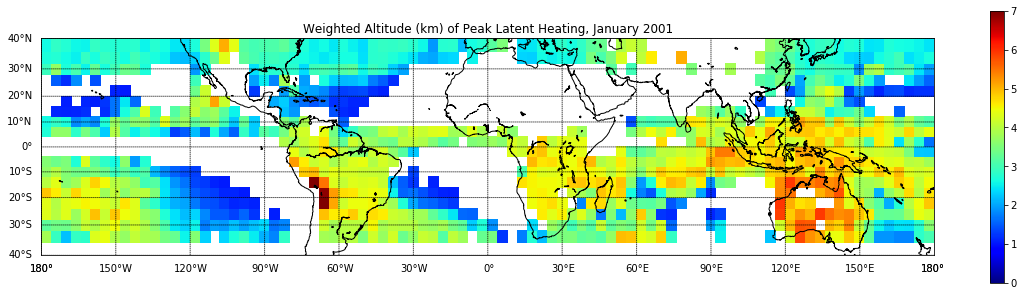

In [4]:
# Calculate the top-heaviness of the latent heating profiles
splitting_level = 5 # 5: 4km
temp_lhp = 0.5*(lhp[:,:,1:] + lhp[:,:,:-1])
nlon = np.size(lhp,0)
nlat = np.size(lhp,1)
dz = altitude_lh[1:] - altitude_lh[:-1]
dz = np.tile(dz, (nlon,nlat,1))

lhp_tot = np.nansum(temp_lhp*dz, axis=2)
lhp_upper = np.nansum(temp_lhp[:,:,splitting_level:]*dz[:,:,splitting_level:], axis=2)
lhp_lower = np.nansum(temp_lhp[:,:,:splitting_level]*dz[:,:,:splitting_level], axis=2)
lhp_upper_frac = lhp_upper/lhp_tot
lhp_lower_frac = lhp_lower/lhp_tot

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-40,urcrnrlon=180.,urcrnrlat=40.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
data = lhp_upper_frac.copy()
data[npixels<700] = np.nan
data = np.transpose(data)
m.pcolor(x, y, data, cmap='jet')
plt.clim(0, 1)
plt.colorbar()
plt.title('Fraction of Latent Heating Above 4km, January 2001');
#fig.savefig('plots/lhpmaxalt_0101_gridded.jpg', format='jpg', bbox_inches='tight');

#fig = plt.figure(num=None, figsize=(20, 5) )
#m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
#            resolution='l',projection='merc')
#m.drawcoastlines()
#m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
#m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
#x, y = m(*np.meshgrid(lon,lat))
#data = lhp_lower_frac.copy()
#data[npixels<700] = np.nan
#data = np.transpose(data)
#m.pcolor(x, y, data, cmap='jet')
#plt.clim(0, 1)
#plt.colorbar()
#plt.title('Fraction of Latent Heating Below Height Threshold');
##fig.savefig('plots/convfrac_gridded_0101.jpg', format='jpg', bbox_inches='tight');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-40,urcrnrlon=180.,urcrnrlat=40.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
data = lhp_max_alt.copy()
data[npixels<700] = np.nan
data = np.transpose(data)
m.pcolor(x, y, data, cmap='jet')
plt.clim(0, 7)
plt.colorbar()
plt.title('Weighted Altitude (km) of Peak Latent Heating, January 2001');
#fig.savefig('plots/lhp_upperfrac_0101_gridded.jpg', format='jpg', bbox_inches='tight');

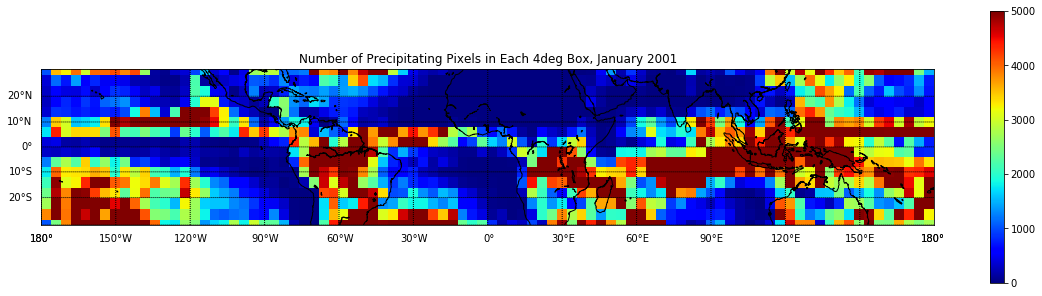

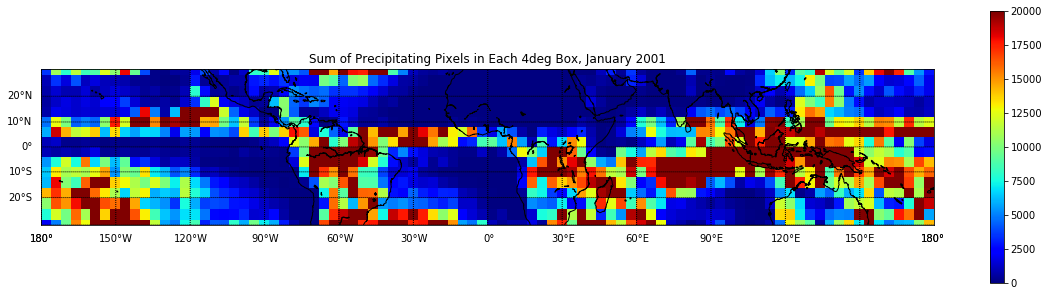

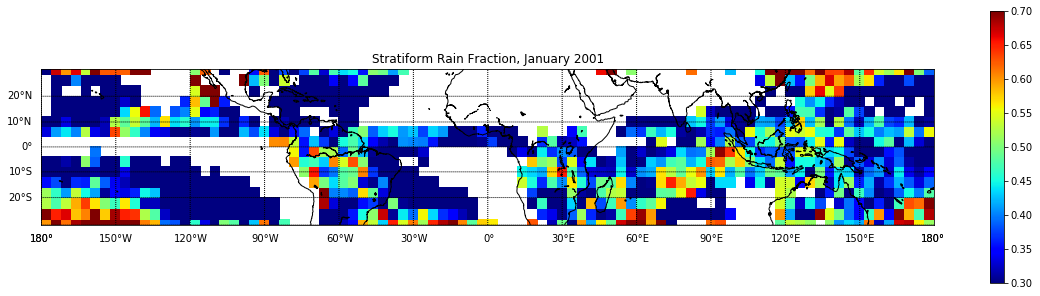

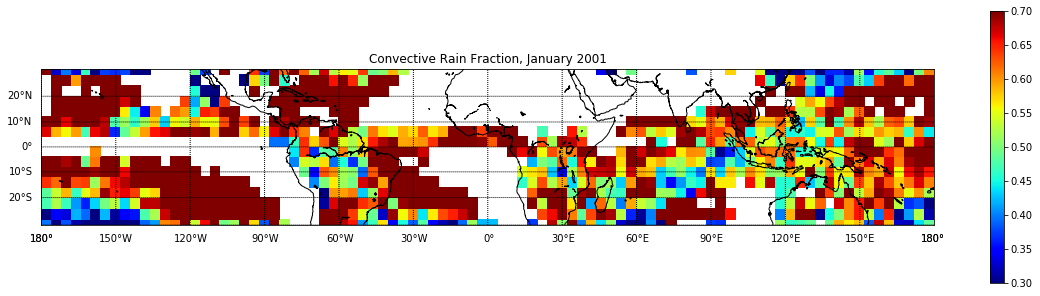

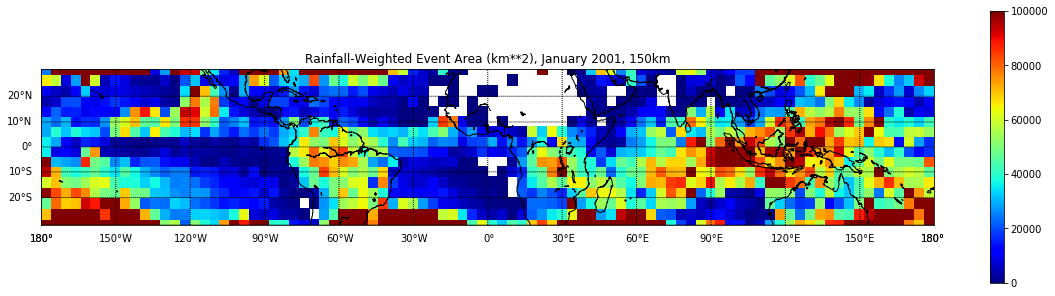

In [5]:
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
m.pcolor(x, y, np.transpose(npixels), cmap='jet')
plt.clim(0, 5000)
plt.colorbar()
plt.title('Number of Precipitating Pixels in Each 4deg Box, January 2001');
#fig.savefig('plots/nevents_0101.jpg', format='jpg', bbox_inches='tight');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
m.pcolor(x, y, np.transpose(rain_sum), cmap='jet')
plt.clim(0, 20000)
plt.colorbar()
plt.title('Sum of Precipitating Pixels in Each 4deg Box, January 2001');
#fig.savefig('nevents_0101.jpg', format='jpg', bbox_inches='tight');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
data = strat_frac.copy()
data[npixels<500] = np.nan
data = np.transpose(data)
m.pcolor(x, y, data, cmap='jet')
plt.clim(0.3, 0.7)
plt.colorbar()
plt.title('Stratiform Rain Fraction, January 2001');
#fig.savefig('plots/stratfrac_gridded_0101.jpg', format='jpg', bbox_inches='tight');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
data = conv_frac.copy()
data[npixels<500] = np.nan
data = np.transpose(data)
m.pcolor(x, y, data, cmap='jet')
plt.clim(0.3, 0.7)
plt.colorbar()
plt.title('Convective Rain Fraction, January 2001');
#fig.savefig('plots/convfrac_gridded_0101.jpg', format='jpg', bbox_inches='tight');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-30,urcrnrlon=180.,urcrnrlat=30.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,10.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,30.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon,lat))
data = event_area_gridded.copy()
#data[npixels<1000] = np.nan
data = np.transpose(data)
m.pcolor(x, y, data, cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
plt.title('Rainfall-Weighted Event Area (km**2), January 2001, 150km');
#fig.savefig('plots/area_gridded_0701_150km.jpg', format='jpg', bbox_inches='tight');

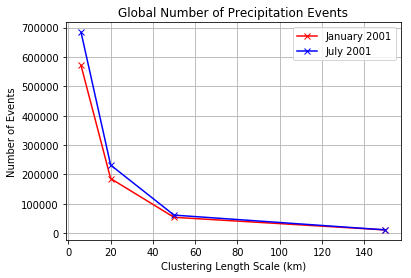

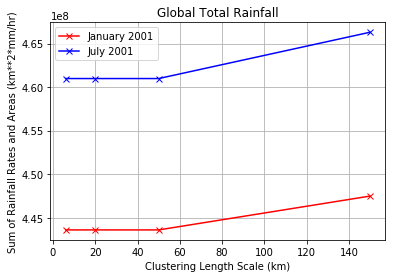

In [6]:
nevents = np.ndarray(shape=8, dtype=float)
total_rainfall = np.ndarray(shape=8, dtype=float)
length_scales = np.array([6, 20, 50, 150])

f = xr.open_dataset('2001_01_event_means6.nc')
nevents[0] = np.size(f.cluster)
total_rainfall[0] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_01_event_means20.nc')
nevents[1] = np.size(f.cluster)
total_rainfall[1] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_01_event_means50.nc')
nevents[2] = np.size(f.cluster)
total_rainfall[2] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_01_event_means150.nc')
nevents[3] = np.size(f.cluster)
total_rainfall[3] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_07_event_means6.nc')
nevents[4] = np.size(f.cluster)
total_rainfall[4] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_07_event_means20.nc')
nevents[5] = np.size(f.cluster)
total_rainfall[5] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_07_event_means50.nc')
nevents[6] = np.size(f.cluster)
total_rainfall[6] = np.nansum(f.event_pr_mean*f.event_area)
f = xr.open_dataset('2001_07_event_means150.nc')
nevents[7] = np.size(f.cluster)
total_rainfall[7] = np.nansum(f.event_pr_mean*f.event_area)
f.close()

fig = plt.figure()
plt.plot(length_scales, nevents[:4],'-rx')
plt.plot(length_scales, nevents[4:],'-bx')
plt.grid()
plt.title('Global Number of Precipitation Events')
plt.xlabel('Clustering Length Scale (km)')
plt.ylabel('Number of Events')
plt.legend(['January 2001','July 2001']);
#fig.savefig('plots/nevents_global.eps', format='eps', bbox_inches='tight');

fig = plt.figure()
plt.plot(length_scales, total_rainfall[:4],'-rx')
plt.plot(length_scales, total_rainfall[4:],'-bx')
plt.grid()
plt.title('Global Total Rainfall')
plt.xlabel('Clustering Length Scale (km)')
plt.ylabel('Sum of Rainfall Rates and Areas (km**2*mm/hr)')
plt.legend(['January 2001','July 2001']);
#fig.savefig('plots/total_rainfall_global.eps', format='eps', bbox_inches='tight');